In [5]:
pip install chardet

Note: you may need to restart the kernel to use updated packages.


In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import chardet

Archivo 2023_Accidentalidad.csv cargado con éxito usando codificación UTF-8-SIG
Archivo 2023_LISTADO_UBICACIONES_NP.csv cargado con éxito usando codificación UTF-8-SIG
Archivo 2024_Accidentalidad.csv cargado con éxito usando codificación ISO-8859-1
Archivo Actuaciones_limpieza_urbana_2023.csv cargado con éxito usando codificación UTF-8-SIG
Archivo Actuaciones_limpieza_urbana_2024.csv cargado con éxito usando codificación UTF-8-SIG
Archivo DATOS_ESTACIONES_AGOSTO_2024.csv cargado con éxito usando codificación UTF-8-SIG
Archivo DATOS_ESTACIONES_JULIO_2024.csv cargado con éxito usando codificación UTF-8-SIG
Archivo DATOS_ESTACIONES_JUNIO_2024.csv cargado con éxito usando codificación UTF-8-SIG
Archivo intensidad_media_dias_laborables_2023-2024.csv cargado con éxito usando codificación UTF-8-SIG
Archivo Listado accidentes 2021.csv cargado con éxito usando codificación UTF-8-SIG
Archivo transporteurbanoparadaslineasautobus.csv cargado con éxito usando codificación ISO-8859-1
Archivo Ubicaci

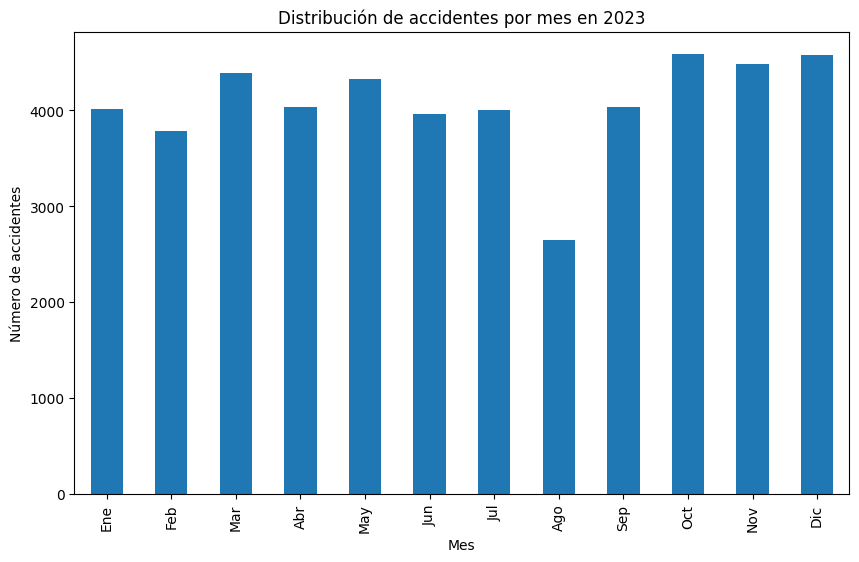

No se encontró la columna 'TIPO_ACCIDENTE' en los datos de 2023


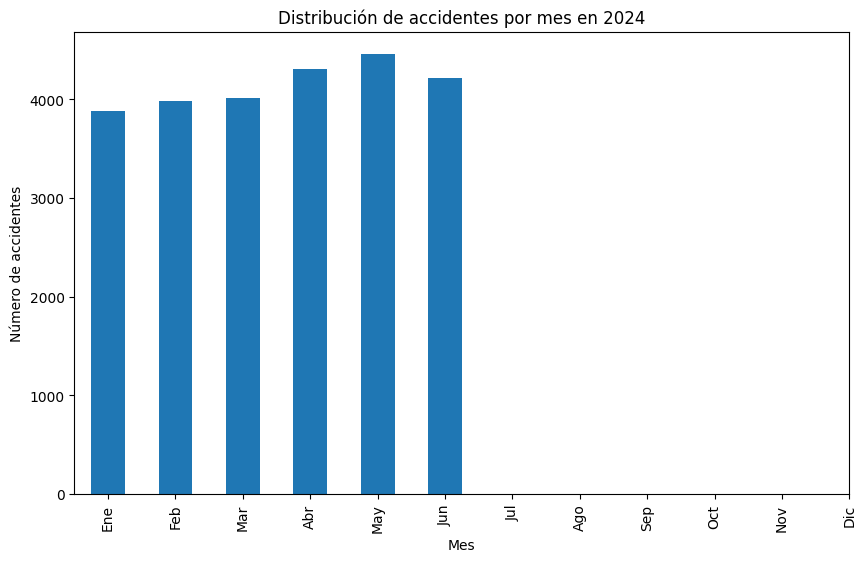

No se encontró la columna 'TIPO_ACCIDENTE' en los datos de 2024
No se pudo identificar una columna de fecha.
No se puede realizar el análisis debido a la falta de columna de fecha.
No se pudo identificar una columna de fecha.
No se puede realizar el análisis debido a la falta de columna de fecha.
No se pudo identificar una columna de fecha.
No se puede realizar el análisis debido a la falta de columna de fecha.
No se pudo identificar una columna de fecha.
No se puede realizar el análisis para 2023 debido a la falta de columna de fecha.
No se pudo identificar una columna de fecha.
No se puede realizar el análisis para 2024 debido a la falta de columna de fecha.
Análisis completo finalizado.


In [14]:
def detect_encoding(file_path):
    with open(file_path, 'rb') as file:
        raw_data = file.read()
    result = chardet.detect(raw_data)
    return result['encoding']

def read_csv_robust(file_path):
    encodings_to_try = ['utf-8', 'iso-8859-1', 'latin1', 'cp1252']
    
    detected_encoding = detect_encoding(file_path)
    encodings_to_try.insert(0, detected_encoding)
    
    for encoding in encodings_to_try:
        try:
            df = pd.read_csv(file_path, encoding=encoding, sep=None, engine='python')
            print(f"Archivo {file_path} cargado con éxito usando codificación {encoding}")
            return df
        except UnicodeDecodeError:
            print(f"Falló la codificación {encoding} para {file_path}")
        except pd.errors.ParserError:
            print(f"Error de análisis con codificación {encoding} para {file_path}")
    
    try:
        with open(file_path, 'rb') as file:
            raw_data = file.read()
        content = raw_data.decode(encoding='latin1', errors='replace')
        df = pd.read_csv(io.StringIO(content), sep=None, engine='python')
        print(f"Archivo {file_path} cargado en modo binario")
        return df
    except Exception as e:
        print(f"No se pudo cargar el archivo {file_path}. Error: {str(e)}")
        return None

def identificar_columna_fecha(df):
    posibles_nombres = ['FECHA', 'Fecha', 'fecha', 'DATE', 'Date', 'date']
    for nombre in posibles_nombres:
        if nombre in df.columns:
            return nombre
    
    columnas_fecha = [col for col in df.columns if 'fecha' in col.lower() or 'date' in col.lower()]
    if columnas_fecha:
        return columnas_fecha[0]
    
    print("No se pudo identificar una columna de fecha.")
    return None

def analizar_accidentes_por_mes(df, año):
    columna_fecha = identificar_columna_fecha(df)
    if not columna_fecha:
        print(f"No se pudo realizar el análisis para {año} debido a la falta de columna de fecha.")
        return
    
    # Convertir la columna de fecha a datetime, especificando el formato
    df[columna_fecha] = pd.to_datetime(df[columna_fecha], format='%d/%m/%Y')
    
    accidentes_por_mes = df.groupby(df[columna_fecha].dt.month).size()
    
    plt.figure(figsize=(10, 6))
    accidentes_por_mes.plot(kind='bar')
    plt.title(f'Distribución de accidentes por mes en {año}')
    plt.xlabel('Mes')
    plt.ylabel('Número de accidentes')
    plt.xticks(range(12), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
    plt.show()

def analizar_relacion_accidentes_estaciones(accidentes_df, estaciones_df, mes):
    columna_fecha_accidentes = identificar_columna_fecha(accidentes_df)
    columna_fecha_estaciones = identificar_columna_fecha(estaciones_df)
    
    if not columna_fecha_accidentes or not columna_fecha_estaciones:
        print("No se puede realizar el análisis debido a la falta de columna de fecha.")
        return
    
    # Convertir las columnas de fecha a datetime, especificando el formato para accidentes
    accidentes_df[columna_fecha_accidentes] = pd.to_datetime(accidentes_df[columna_fecha_accidentes], format='%d/%m/%Y')
    estaciones_df[columna_fecha_estaciones] = pd.to_datetime(estaciones_df[columna_fecha_estaciones])
    
    accidentes_mes = accidentes_df[accidentes_df[columna_fecha_accidentes].dt.month == mes]
    
    accidentes_por_dia = accidentes_mes.groupby(accidentes_mes[columna_fecha_accidentes].dt.date).size()
    
    if 'VALOR' not in estaciones_df.columns:
        print("No se encontró la columna 'VALOR' en los datos de estaciones.")
        return
    
    estaciones_por_dia = estaciones_df.groupby(estaciones_df[columna_fecha_estaciones].dt.date)['VALOR'].mean()
    
    datos_combinados = pd.DataFrame({'Accidentes': accidentes_por_dia, 'Valor_Estacion': estaciones_por_dia})
    
    correlacion = datos_combinados['Accidentes'].corr(datos_combinados['Valor_Estacion'])
    
    print(f"Correlación entre accidentes y valor de estaciones en {mes}/2024: {correlacion}")
    
    plt.figure(figsize=(10, 6))
    plt.scatter(datos_combinados['Valor_Estacion'], datos_combinados['Accidentes'])
    plt.title(f'Relación entre accidentes y valor de estaciones en {mes}/2024')
    plt.xlabel('Valor promedio de estaciones')
    plt.ylabel('Número de accidentes')
    plt.show()

def analizar_tipos_accidentes(df, año):
    if 'TIPO_ACCIDENTE' in df.columns:
        tipos_accidentes = df['TIPO_ACCIDENTE'].value_counts()
        
        plt.figure(figsize=(12, 6))
        tipos_accidentes.plot(kind='bar')
        plt.title(f'Tipos de accidentes más comunes en {año}')
        plt.xlabel('Tipo de accidente')
        plt.ylabel('Número de accidentes')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No se encontró la columna 'TIPO_ACCIDENTE' en los datos de {año}")

def analizar_relacion_limpieza_accidentes(accidentes_df, limpieza_df, año):
    columna_fecha_accidentes = identificar_columna_fecha(accidentes_df)
    columna_fecha_limpieza = identificar_columna_fecha(limpieza_df)
    
    if not columna_fecha_accidentes or not columna_fecha_limpieza:
        print(f"No se puede realizar el análisis para {año} debido a la falta de columna de fecha.")
        return
    
    # Convertir las columnas de fecha a datetime, especificando el formato para accidentes
    accidentes_df[columna_fecha_accidentes] = pd.to_datetime(accidentes_df[columna_fecha_accidentes], format='%d/%m/%Y')
    limpieza_df[columna_fecha_limpieza] = pd.to_datetime(limpieza_df[columna_fecha_limpieza])
    
    accidentes_por_dia = accidentes_df.groupby(accidentes_df[columna_fecha_accidentes].dt.date).size()
    limpieza_por_dia = limpieza_df.groupby(limpieza_df[columna_fecha_limpieza].dt.date).size()
    
    datos_combinados = pd.DataFrame({'Accidentes': accidentes_por_dia, 'Actuaciones_Limpieza': limpieza_por_dia})
    
    correlacion = datos_combinados['Accidentes'].corr(datos_combinados['Actuaciones_Limpieza'])
    
    print(f"Correlación entre accidentes y actuaciones de limpieza en {año}: {correlacion}")
    
    plt.figure(figsize=(10, 6))
    plt.scatter(datos_combinados['Actuaciones_Limpieza'], datos_combinados['Accidentes'])
    plt.title(f'Relación entre accidentes y actuaciones de limpieza en {año}')
    plt.xlabel('Número de actuaciones de limpieza')
    plt.ylabel('Número de accidentes')
    plt.show()

# Lista de archivos a cargar
archivos = [
    '2023_Accidentalidad.csv',
    '2023_LISTADO_UBICACIONES_NP.csv',
    '2024_Accidentalidad.csv',
    'Actuaciones_limpieza_urbana_2023.csv',
    'Actuaciones_limpieza_urbana_2024.csv',
    'DATOS_ESTACIONES_AGOSTO_2024.csv',
    'DATOS_ESTACIONES_JULIO_2024.csv',
    'DATOS_ESTACIONES_JUNIO_2024.csv',
    'intensidad_media_dias_laborables_2023-2024.csv',
    'Listado accidentes 2021.csv',
    'transporteurbanoparadaslineasautobus.csv',
    'UbicacionEstacionesPermanentesSentidos.csv',
    'uso-de-autobuses.csv',
]

# Diccionario para almacenar los DataFrames
dataframes = {}

# Cargar cada archivo
for archivo in archivos:
    df = read_csv_robust(archivo)
    if df is not None:
        dataframes[archivo] = df

# Verificar los DataFrames cargados
for nombre, df in dataframes.items():
    print(f"\nPrimeras 5 filas de {nombre}:")
    print(df.head())
    print(f"Forma del DataFrame: {df.shape}")
    print(f"Columnas: {df.columns.tolist()}")
    print("\n" + "="*50 + "\n")

# Verificar qué archivos se cargaron correctamente
archivos_cargados = list(dataframes.keys())
print("Archivos cargados exitosamente:")
for archivo in archivos_cargados:
    print(f"- {archivo}")

print("\nArchivos que no se pudieron cargar:")
for archivo in archivos:
    if archivo not in archivos_cargados:
        print(f"- {archivo}")

# Asignar DataFrames específicos
accidentalidad_2023 = dataframes.get('2023_Accidentalidad.csv')
accidentalidad_2024 = dataframes.get('2024_Accidentalidad.csv')
estaciones_junio = dataframes.get('DATOS_ESTACIONES_JUNIO_2024.csv')
estaciones_julio = dataframes.get('DATOS_ESTACIONES_JULIO_2024.csv')
estaciones_agosto = dataframes.get('DATOS_ESTACIONES_AGOSTO_2024.csv')
limpieza_2023 = dataframes.get('Actuaciones_limpieza_urbana_2023.csv')
limpieza_2024 = dataframes.get('Actuaciones_limpieza_urbana_2024.csv')

# Imprimir columnas de los DataFrames principales
for nombre, df in [('accidentalidad_2024', accidentalidad_2024), 
                   ('estaciones_junio', estaciones_junio),
                   ('estaciones_julio', estaciones_julio),
                   ('estaciones_agosto', estaciones_agosto)]:
    if df is not None:
        print(f"\nColumnas en {nombre}:")
        print(df.columns)
    else:
        print(f"\n{nombre} no se pudo cargar.")

# Imprimir información sobre las columnas de fecha
for nombre, df in [('accidentalidad_2023', accidentalidad_2023), 
                   ('accidentalidad_2024', accidentalidad_2024)]:
    if df is not None:
        columna_fecha = identificar_columna_fecha(df)
        if columna_fecha:
            print(f"\nPrimeras 5 fechas en {nombre}:")
            print(df[columna_fecha].head())
        else:
            print(f"\nNo se encontró columna de fecha en {nombre}")

# Realizar análisis
if accidentalidad_2023 is not None:
    analizar_accidentes_por_mes(accidentalidad_2023, 2023)
    analizar_tipos_accidentes(accidentalidad_2023, 2023)

if accidentalidad_2024 is not None:
    analizar_accidentes_por_mes(accidentalidad_2024, 2024)
    analizar_tipos_accidentes(accidentalidad_2024, 2024)

if accidentalidad_2024 is not None and estaciones_junio is not None:
    analizar_relacion_accidentes_estaciones(accidentalidad_2024, estaciones_junio, 6)

if accidentalidad_2024 is not None and estaciones_julio is not None:
    analizar_relacion_accidentes_estaciones(accidentalidad_2024, estaciones_julio, 7)

if accidentalidad_2024 is not None and estaciones_agosto is not None:
    analizar_relacion_accidentes_estaciones(accidentalidad_2024, estaciones_agosto, 8)

if accidentalidad_2023 is not None and limpieza_2023 is not None:
    analizar_relacion_limpieza_accidentes(accidentalidad_2023, limpieza_2023, 2023)

if accidentalidad_2024 is not None and limpieza_2024 is not None:
    analizar_relacion_limpieza_accidentes(accidentalidad_2024, limpieza_2024, 2024)

print("Análisis completo finalizado.")

In [31]:
# Cargar el archivo train.csv desde la misma carpeta
E1 = pd.read_csv('2023_Accidentalidad.csv', sep=None, engine='python')
E2 = pd.read_csv('2023_LISTADO_UBICACIONES_NP.csv', sep=None, engine='python')
E3 = pd.read_csv('Actuaciones_limpieza_urbana_2023.csv', sep=None, engine='python')
E4 = pd.read_csv('Actuaciones_limpieza_urbana_2024.csv', sep=None, engine='python')
E5 = pd.read_csv('DATOS_ESTACIONES_JULIO_2024.csv', sep=None, engine='python')
E6 = pd.read_csv('DATOS_ESTACIONES_JUNIO_2024.csv', sep=None, engine='python')
E7 = pd.read_csv('intensidad_media_dias_laborables_2023-2024.csv', sep=None, engine='python')
E8 = pd.read_csv('Listado accidentes 2021.csv', sep=None, engine='python')
E9 = pd.read_csv('UbicacionEstacionesPermanentesSentidos.csv', sep=None, engine='python')
E10 = pd.read_csv('uso-de-autobuses.csv', sep=None, engine='python')

result = pd.concat([E1, E2, E3, E4, E5, E6, E7, E8, E9, E10], axis=0)

print(result.head())


  ﻿num_expediente       fecha     hora            localizacion numero  \
0     2023S000001  01/01/2023  1:15:00  AVDA. ALFONSO XIII, 33     33   
1     2023S000001  01/01/2023  1:15:00  AVDA. ALFONSO XIII, 33     33   
2     2023S000001  01/01/2023  1:15:00  AVDA. ALFONSO XIII, 33     33   
3     2023S000001  01/01/2023  1:15:00  AVDA. ALFONSO XIII, 33     33   
4     2023S000001  01/01/2023  1:15:00  AVDA. ALFONSO XIII, 33     33   

   cod_distrito   distrito tipo_accidente estado_meteorológico tipo_vehiculo  \
0           5.0  CHAMARTÍN        Alcance            Despejado  Todo terreno   
1           5.0  CHAMARTÍN        Alcance            Despejado  Todo terreno   
2           5.0  CHAMARTÍN        Alcance            Despejado  Todo terreno   
3           5.0  CHAMARTÍN        Alcance            Despejado  Todo terreno   
4           5.0  CHAMARTÍN        Alcance            Despejado  Todo terreno   

   ... Sentido Orient. ﻿Línea  Año Tipo de transporte  \
0  ...     NaN     NaN 

In [32]:
result.to_csv('resultado_concatenado.csv', index=False)


In [34]:
# Cargar el archivo train.csv desde la misma carpeta
td = pd.read_csv('resultado_concatenado.csv')

# Ver las primeras filas del archivo
td.head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8440\4021125427.py:2: DtypeWarning: Columns (0,1,2,3,4,6,7,8,9,10,11,12,14,17,19,20,21,22,23,24,25,26,27,30,64,65,66,80,82,83,84,85,86,87,88,89,93,94,98,100,101,102,104,105,107) have mixed types. Specify dtype option on import or set low_memory=False.
  td = pd.read_csv('resultado_concatenado.csv')


,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,...,Sentido,Orient.,﻿Línea,Año,Tipo de transporte,Número anual de pasajeros,Expediciones por día laborable,Viajeros por día,Viajeros por expedición,Kilómetros anuales realizados
0,2023S000001,01/01/2023,1:15:00,"AVDA. ALFONSO XIII, 33",33,5.0,CHAMARTÍN,Alcance,Despejado,Todo terreno,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023S000001,01/01/2023,1:15:00,"AVDA. ALFONSO XIII, 33",33,5.0,CHAMARTÍN,Alcance,Despejado,Todo terreno,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023S000001,01/01/2023,1:15:00,"AVDA. ALFONSO XIII, 33",33,5.0,CHAMARTÍN,Alcance,Despejado,Todo terreno,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023S000001,01/01/2023,1:15:00,"AVDA. ALFONSO XIII, 33",33,5.0,CHAMARTÍN,Alcance,Despejado,Todo terreno,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023S000001,01/01/2023,1:15:00,"AVDA. ALFONSO XIII, 33",33,5.0,CHAMARTÍN,Alcance,Despejado,Todo terreno,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
